# Demo of data cube functionalities: Ozone hole size computation
Here we demonstrate how to analyse the ozone hole area as a function of time on the basis of Sentinel 5P/TROPOMI-observations using EOC data cube functionalities. 

## Do some preparation (only need to be done once for each environment).

In [12]:
pip install pystac_client

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install odc.stac

     |████████████████████████████████| 56 kB 1.6 MB/s eta 0:00:011
     |████████████████████████████████| 1.2 MB 6.1 MB/s eta 0:00:01
  Using cached toolz-0.12.0-py3-none-any.whl (55 kB)
     |████████████████████████████████| 21.3 MB 83.5 MB/s eta 0:00:01
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached xarray-2023.1.0-py3-none-any.whl (973 kB)
  Using cached affine-2.4.0-py3-none-any.whl (15 kB)
     |████████████████████████████████| 17.3 MB 87.9 MB/s eta 0:00:01
     |████████████████████████████████| 122 kB 94.0 MB/s eta 0:00:01
     |████████████████████████████████| 736 kB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 30.7 MB/s  eta 0:00:01
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
     |████████████████████████████████| 173 kB 97.2 MB/s eta 0:00:01
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Using cached click_plug

In [11]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [14]:
pip install matplotlib

     |████████████████████████████████| 9.2 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 153.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 85.0 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 135.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Let's start with some relevant settings
<div class="alert alert-block alert-success">
To identify the relevant STAC collection, visit https://geoservice.dlr.de/eoc/ogc/stac with your browser.
</div>

In [1]:
stacapi_endpoint = "https://geoservice.dlr.de/eoc/ogc/stac/"
collections = ["S5P_TROPOMI_L3_P1D_O3"]

bbox = [-180, -90, 180, -30]
dates_from_to = ["2023-08-01", "2023-10-04"]
resolution=0.09 # 0.09 deg is original product resolution

earth_circumference_poles = 40007.863 # km
earth_circumference_eq = 40075.017 # km

ozone_threshold = 220.0 # DU

## Now let's connect to the STAC catalog

<div class="alert alert-block alert-success">
Import library and connect to the EOC STAC catalog service.

This is just a "connect", no data is going to be downloaded.
</div>

In [2]:
from pystac_client import Client

In [3]:
catalog = Client.open(
    url=stacapi_endpoint
)

## Let's discover datasets
<div class="alert alert-block alert-success">
Data discovery is performed according to our settings
</div>

In [4]:
%%time

stac_items = catalog.search(
    collections=collections, 
    datetime=dates_from_to, 
    method="GET", 
    filter_lang="cql2-text",
    max_items=1000
).item_collection()

CPU times: user 59.9 ms, sys: 0 ns, total: 59.9 ms
Wall time: 2.75 s


In [5]:
stac_items

*--> Now we identified the relevant datasets which we need for our research.*

## Load the data to local storage

<div class="alert alert-block alert-success">
Now the data of the identifed data sets is going to be downloaded to the local client.

You con concentrate on your work. All ugly work such as 
- re-projection or
- area-slicing 
 
is done on the server.</div>

In [6]:
from odc.stac import stac_load
import xarray as xr

In [7]:
%%time

ozone_column = stac_load(
    stac_items,
    bands=["o3"],
    crs="EPSG:4326",
    resolution=resolution,
    lon=(bbox[0], bbox[2]),
    lat=(bbox[1], bbox[3]),)

print ("Data is extracted on the server and downloaded to local storage.")

Data is extracted on the server and downloaded to local storage.
CPU times: user 10.2 s, sys: 12 s, total: 22.2 s
Wall time: 2min 23s


In [8]:
ozone_column

<xarray.Dataset>
Dimensions:      (latitude: 667, longitude: 4000, time: 65)
Coordinates:
  * latitude     (latitude) float64 -30.02 -30.11 -30.2 ... -89.78 -89.86 -89.95
  * longitude    (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2023-08-01 2023-08-02 ... 2023-10-04
Data variables:
    o3           (time, latitude, longitude) float32 9.969e+36 ... 124.3

## Now do some auxiliary calculations: Compute area per pixel
<div class="alert alert-block alert-success">
Compute the area in square kilometers per pixel in L3-satellite-data projection (EPSG:4326). 

Area $a(\lambda, \phi)$ is based on the projection of the satellite L3 data as retrieved from the EOC Geoservice:

$a(\lambda, \phi) = d_x(equator) \cdot \cos(\phi) \cdot d_y \cdot resolution$
</div>

In [9]:
import math
import numpy as np

nlat = len(ozone_column.latitude)
nlon = len(ozone_column.longitude)

area = np.zeros((nlat,nlon), dtype=np.double)

extend_ns = (earth_circumference_poles/2.0) / 180. * resolution
for ilat in range(nlat):
    extend_ew = earth_circumference_eq * math.cos(ozone_column.latitude[ilat]/180.*math.pi) / 360. * resolution
    for ilon in range(nlon):
        area[ilat,ilon] = extend_ns * extend_ew


area_xr = xr.DataArray(area, coords= {"latitude": ozone_column.latitude, "longitude": ozone_column.longitude})
area_xr

<xarray.DataArray (latitude: 667, longitude: 4000)>
array([[8.67688927e+01, 8.67688927e+01, 8.67688927e+01, ...,
        8.67688927e+01, 8.67688927e+01, 8.67688927e+01],
       [8.66900474e+01, 8.66900474e+01, 8.66900474e+01, ...,
        8.66900474e+01, 8.66900474e+01, 8.66900474e+01],
       [8.66109882e+01, 8.66109882e+01, 8.66109882e+01, ...,
        8.66109882e+01, 8.66109882e+01, 8.66109882e+01],
       ...,
       [3.93511888e-01, 3.93511888e-01, 3.93511888e-01, ...,
        3.93511888e-01, 3.93511888e-01, 3.93511888e-01],
       [2.36107521e-01, 2.36107521e-01, 2.36107521e-01, ...,
        2.36107521e-01, 2.36107521e-01, 2.36107521e-01],
       [7.87025717e-02, 7.87025717e-02, 7.87025717e-02, ...,
        7.87025717e-02, 7.87025717e-02, 7.87025717e-02]])
Coordinates:
  * latitude   (latitude) float64 -30.02 -30.11 -30.2 ... -89.78 -89.86 -89.95
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0

## Mask out all ozone observations >= 220 DU (WMO criterium for ozone hole condition)

<div class="alert alert-block alert-success">
Only cells with ozone columns < 220 DU are remaining.
</div>

In [10]:
ozone_hole = ozone_column.o3.where(ozone_column.o3 < ozone_threshold, 0) 

## Prepare plotting of timeseries

<div class="alert alert-block alert-success">
Use "Geopandas" timeseries processing.

$ozonehole = \sum_{ij} a_{ij} \mathrm{\ where\ } ozone_{ij} < 220 DU$
</div>

In [11]:
import pandas as pd

pd.__version__

'2.0.3'

In [12]:
daterange = np.array(ozone_column.time)
cols = ["datetime", 'size_ozone_hole', 'mean_O3_value']

result = []
for i in range(0, len(ozone_hole.time)):
    ozone_hole_area = area_xr.where(ozone_hole.isel(time=i) != 0, np.nan)
    size_hole_in_km2 = np.array(ozone_hole_area.sum())

    result.append([daterange[i], size_hole_in_km2.round(2)/1000000, np.array(ozone_hole.isel(time=i).mean())])
    
df_ozone_hole = pd.DataFrame(result, columns=cols)
df_ozone_hole

datetime  size_ozone_hole mean_O3_value
0  2023-08-01         0.465779     1.0120476
1  2023-08-02         0.766681     1.6748397
2  2023-08-03         0.152626    0.35741448
3  2023-08-04         0.309330    0.70260465
4  2023-08-05         1.282763     2.7660265
..        ...              ...           ...
60 2023-09-30        21.626477     58.531498
61 2023-10-01        22.014644      58.67384
62 2023-10-02        21.924252      56.59337
63 2023-10-03        21.753539      55.88885
64 2023-10-04        21.813658     56.404713

[65 rows x 3 columns]

## Now create the timeseries plot: Ozone hole area as a function of time from S5P/TROPOMI observations

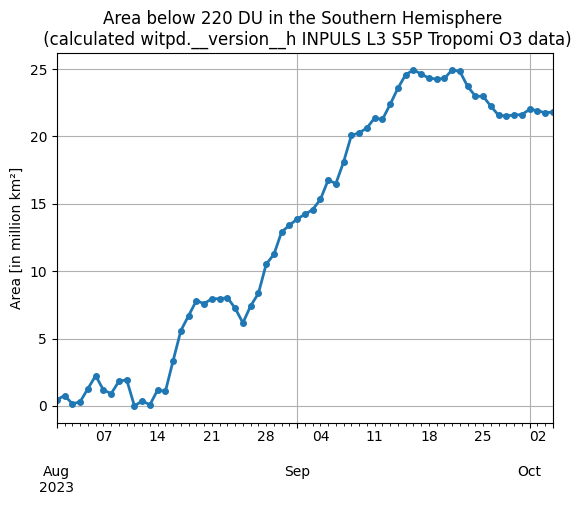

In [15]:
import matplotlib.pyplot as plt

df_ozone_hole.plot(
    x ='datetime', 
    y='size_ozone_hole', 
    legend=None, 
    kind='line', marker='o', markersize = 4, lw = 2, 
    title = "Area below 220 DU in the Southern Hemisphere \n (calculated witpd.__version__h INPULS L3 S5P Tropomi O3 data)")
plt.xlabel('')
plt.ylabel('Area [in million km²]')
plt.grid()
plt.show()

In [16]:
pd.__version__

'2.0.3'

## Now let's compare both algorithms

<div class="alert alert-block alert-success">
Compare information on ozone hole size derived from STAC metadata with results obtained by our approach.
</div>

In [17]:
size_ozone_hole_computed = 0

for i in range(len(stac_items)):
    x = stac_items.items[i].properties["datetime"]

    for j in range(len(df_ozone_hole)):
        y = df_ozone_hole["datetime"][j].strftime("%Y-%m-%dT%H:%M:%SZ")
        # print (x,y)
        if x == y:
            size_ozone_hole_computed = df_ozone_hole["size_ozone_hole"][j]

    try:
        size_ozone_hole_metadata = stac_items.items[i].properties["s5p:south_pole_ozone_hole_area"]
    except:
        size_ozone_hole_metadata = np.nan
    
    print (i, stac_items.items[i].properties["datetime"], size_ozone_hole_computed, size_ozone_hole_metadata/1e6, size_ozone_hole_computed-size_ozone_hole_metadata/1e6)

0 2023-10-04T00:00:00Z 21.81365821 21.798092 0.015566209999999359
1 2023-10-03T00:00:00Z 21.75353934 21.741516 0.012023339999998939
2 2023-10-02T00:00:00Z 21.924252 21.91087 0.013382000000000005
3 2023-10-01T00:00:00Z 22.0146441 21.998634 0.01601010000000258
4 2023-09-30T00:00:00Z 21.62647652 21.609182 0.01729452000000009
5 2023-09-29T00:00:00Z 21.59490387 21.569372 0.025531869999998236
6 2023-09-28T00:00:00Z 21.53040123 21.511862 0.01853922999999824
7 2023-09-27T00:00:00Z 21.56490156 21.548874 0.01602755999999772
8 2023-09-26T00:00:00Z 22.242348030000002 22.225592 0.016756030000003364
9 2023-09-25T00:00:00Z 22.97839471 22.96629 0.01210470999999913
10 2023-09-24T00:00:00Z 22.99205362 22.977142 0.01491161999999946
11 2023-09-23T00:00:00Z 23.71388691 23.701204 0.01268290999999877
12 2023-09-22T00:00:00Z 24.82340027 24.8063 0.01710027000000025
13 2023-09-21T00:00:00Z 24.94365371 24.931174 0.012479710000000921
14 2023-09-20T00:00:00Z 24.30860273 24.290028 0.018574730000000983
15 2023-09-19